# TESTING OLD ARCHITECTURES FOR ASL

## Installing packages and downloading dataset

In [46]:
%pip install tensorflow
%pip install --user kaggle
%pip install matplotlib
%pip install opencv-python
%pip install numpy
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need t

In [47]:
import numpy as np
import kaggle
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split

In [48]:
dataset = 'ayuraj/asl-dataset'

In [49]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files(dataset,path='.')

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset


In [50]:
!unzip -f asl-dataset.zip
#removing duplicate foldeer that gets created inside the dataset
!rm -rf asl_dataset/asl_dataset

Archive:  asl-dataset.zip


In [51]:
#quickly checking the number of classes
!find asl_dataset -type d -mindepth 1 | wc -l

      36


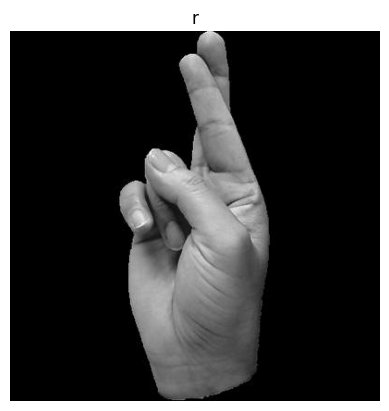

In [52]:
DATADIR = 'asl_dataset'
CATEGORIES = os.listdir(DATADIR)

#Visualizing the first image from the dataset
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array,cmap='gray')
        plt.title(category)
        plt.axis('off')
        break
    break

In [53]:
#Re-sizing to 32x32 as per LeNet-5 architecture
IMG_SIZE = 32
def create_training_data():
    training_data=[]
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
          training_data.append([new_array,class_num])
    return training_data

training_data = create_training_data()

(-0.5, 31.5, 31.5, -0.5)

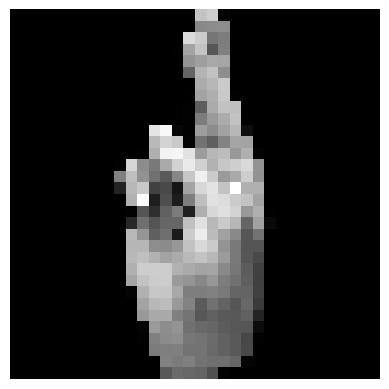

In [54]:
plt.imshow(training_data[0][0],cmap='gray')
plt.axis('off')

In [55]:
random.shuffle(training_data)

In [56]:
X=[]
y=[]

In [57]:
# creating the target and features
for feature,label in training_data:
    X.append(feature)
    y.append(label)
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_one_hot = tf.keras.utils.to_categorical(y,num_classes=len(CATEGORIES))
y_one_hot = np.array(y_one_hot).reshape(-1,36)

In [58]:
#augmenting data to prevent overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [60]:
X = data_augmentation(X)

In [62]:
X_train,X_test,y_train,y_test = train_test_split(np.array(X),y_one_hot)

## LeNet-5


### NOTES :  

- LeNet-5 uses activations after pooling rather than after convolutions 

- it pretty much exclusively uses tanh/sigmoid for activation except the  output layer

![LeNet-5](Images/LeNet-5.svg)

In [63]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,1)),
    tf.keras.layers.Conv2D(6,(5,5),1),
    tf.keras.layers.AveragePooling2D((2,2),2),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Conv2D(16,(5,5),1),
    tf.keras.layers.AveragePooling2D((2,2),2),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120,activation='tanh'),
    tf.keras.layers.Dense(84,activation='tanh'),
    tf.keras.layers.Dense(36,activation='softmax'),

])

In [64]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 36)             │         3,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,916 (249.67 KB)

 Trainable params: 63,916 (249.67 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
History = model.fit(X_train,
          y_train,
          64,
          epochs=10,
          validation_data=[X_test,y_test])

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0535 - loss: 3.5692 - val_accuracy: 0.1017 - val_loss: 3.2860
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1800 - loss: 3.0475 - val_accuracy: 0.1526 - val_loss: 2.9200
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2823 - loss: 2.6515 - val_accuracy: 0.2305 - val_loss: 2.6327
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3720 - loss: 2.3249 - val_accuracy: 0.2687 - val_loss: 2.4782
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4264 - loss: 2.1172 - val_accuracy: 0.2989 - val_loss: 2.2893
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4772 - loss: 1.9189 - val_accuracy: 0.3498 - val_loss: 2.1823
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5078 - loss: 1.7461 - val_accuracy: 0.3211 - val_loss: 2.1505
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5556 - loss: 1.6234 - val_accuracy: 0.3990 - val_loss:

20/20 - 0s - 2ms/step - accuracy: 0.3959 - loss: 1.9497


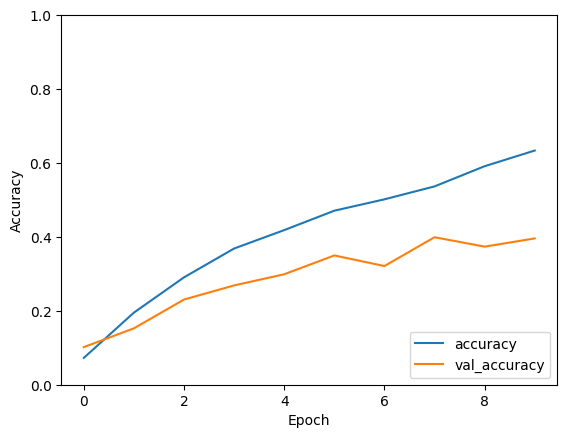

In [67]:

plt.plot(History.history['accuracy'], label='accuracy')
plt.plot(History.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

## ANALYSIS :
- firstly the dataset is quite small for from scratch training of ASL , normally one would use this on a pre-trained model and its hard not to overfit the dataset

- 32x32 images as input are bad in this situation, even the human eye can barely differentiate a lot of the ASL signs. 1 and r for example 

- the data augmentation for training set helps mitigate the overfitting to an extent but as soon as input goes beyond 32x32 , the model seemingly overfits training set 

- LeNet-5 also uses way less parameters compared to modern CNNs and also uses some weird techniques like activating after pooling 